In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

In [5]:
def data_start(label):
    f = uproot.pandas.iterate(f"../outputs/{label}/trees/*.root", "t")
    data = pd.concat([j for j in f])[['label', 'beam_energy', 'mass', 'procedure', 'mass_reco']]
    return data

In [7]:
data11_start = data_start("11")
data19_start = data_start("19")
data12_start = data_start("12")
data17_start = data_start("17")
dataModelNew_start = data_start("model_new")
dataModelOld_start = data_start("model_old")

In [8]:
data = dict()
data['11'] = data11_start.set_index(['label'])
data['12'] = data12_start.set_index(['label'])
data['17'] = data17_start.set_index(['label'])
data['19'] = data19_start.set_index(['label'])
#внимательнее, для 19 нужно New
data['model'] = dataModelOld_start.set_index(['label'])

### Вот так выглядит распределение по инвариантной массе

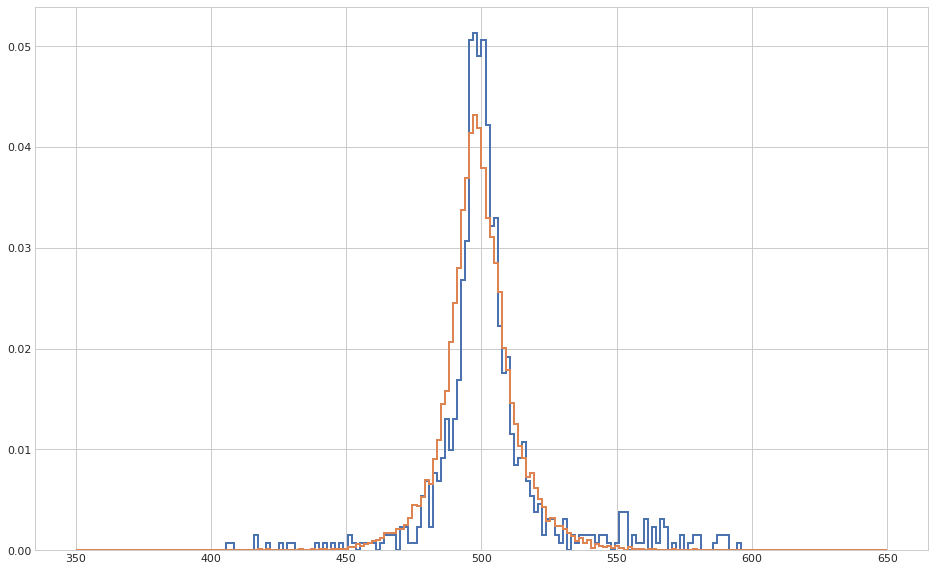

In [38]:
year = '11'
emin, emax = 550, 1100
plt.hist(data=data[year].query('procedure!=2&beam_energy>@emin&beam_energy<=@emax&abs(mass_reco-500)<100'), 
         range=(350, 650), x='mass_reco', bins=200, density=True, label=year, histtype="step", lw=2);
plt.hist(data=data['model'].query('procedure!=2&beam_energy>@emin&beam_energy<=@emax&abs(mass_reco-500)<100'), 
         range=(350, 650), x='mass_reco', bins=200, density=True, label="model", histtype="step", lw=2);

In [39]:
data[year].groupby('label').agg({'procedure':np.size}).tail()

,procedure
label,
950.0,18
962.5,23
975.0,22
987.5,22
1000.0,20


In [40]:
def rec_eff(data):
    rec = pd.pivot_table( data.query('abs(mass_reco-497.6)<5')[['procedure']],  
                         index='label', aggfunc=np.size, columns=['procedure']).fillna(0)
    rec.columns = ['kf', 'st', 'bt']
    rec['kf'] += rec['bt']
    rec['st'] += rec['bt']
    rec['eff'] = (rec['bt']+1.)/(rec['kf']+2)
    rec['err'] = np.sqrt( (rec.bt+1)*(rec.bt+2)/(rec.kf+2)/(rec.kf+3) - np.square((rec.bt+1)/(rec.kf+2)) )
    rec.reset_index(inplace=True)
    return rec

In [41]:
rec= dict()
rec['11'] = rec_eff(data['11'])
rec['12'] = rec_eff(data['12'])
rec['17'] = rec_eff(data['17'])
rec['19'] = rec_eff(data['19'])
rec['model'] = rec_eff(data['model'])

In [42]:
def merging(data, line_from, line_to):
    data['weight'] = data.label*data.kf
    summary = data.loc[line_from:line_to].sum()
    data.loc[line_from:line_to, 'label'] = summary.weight/summary.kf
    data = data.groupby('label').agg({'kf':np.sum, 'st':np.sum, 'bt':np.sum}).reset_index()
    data['eff'] = (data['bt']+1.)/(data['kf']+2)
    data['err'] = np.sqrt( (data.bt+1)*(data.bt+2)/(data.kf+2)/(data.kf+3) - np.square((data.bt+1)/(data.kf+2)) )
    return data

In [56]:
rec[year] = merging(rec[year], 13, 22)

In [57]:
rec[year]

,label,kf,st,bt,eff,err
0,525.000000,287.0,455.0,281.0,0.975779,0.009028
1,537.500000,272.0,527.0,264.0,0.967153,0.010748
2,550.000000,122.0,191.0,115.0,0.935484,0.021973
3,562.500000,98.0,221.0,97.0,0.980000,0.013931
4,575.000000,42.0,64.0,41.0,0.954545,0.031051
5,587.500000,38.0,87.0,35.0,0.900000,0.046852
6,600.000000,18.0,36.0,17.0,0.900000,0.065465
7,612.500000,25.0,65.0,25.0,0.962963,0.035690
8,634.210526,19.0,41.0,18.0,0.904762,0.062584
9,656.250000,22.0,33.0,21.0,0.916667,0.055277


In [58]:
def model_eff(x):
    rec_eff = np.interp(x, rec['model'].label, rec['model'].eff )
    rec_err = np.interp(x, rec['model'].label, rec['model'].err )
    return ( rec_eff, rec_err )
def add_correction(rec):
    rec['eff_m'] = model_eff(rec.label)[0]
    rec['err_m'] = model_eff(rec.label)[1]
    rec['correction'] = rec.eff/rec.eff_m
    rec['correction_error'] = rec.correction*np.sqrt( (rec.err/rec.eff)**2 + (rec.err_m/rec.eff_m)**2 )
    return rec

In [59]:
rec['19'] = add_correction(rec['19'])
rec['17'] = add_correction(rec['17'])
rec['12'] = add_correction(rec['12'])
rec['11'] = add_correction(rec['11'])

Картинка с эффективностью реконструкции для моделирования и эксперимента

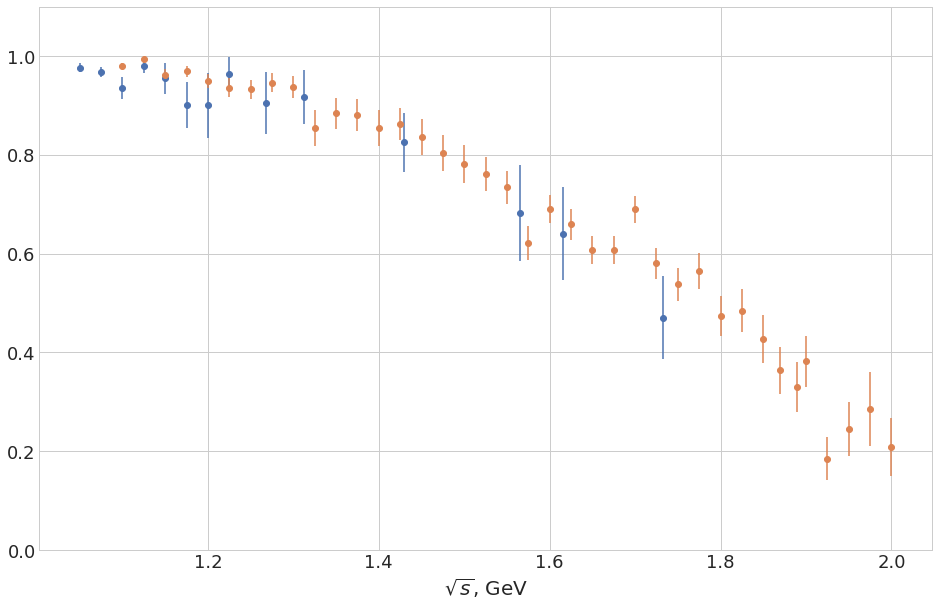

In [60]:
# year = '17'
plt.errorbar(x=rec[year]['label']*2e-3, y=rec[year]['eff'], yerr=rec[year]['err'], fmt='o')
plt.errorbar(x=rec['model']['label']*2e-3, y=rec['model']['eff'], yerr=rec['model']['err'], fmt='o')
plt.xlabel("$\sqrt{s}$, GeV", fontsize=20);
ax = plt.gca()
ax.tick_params(labelsize=18)
ax.set_ylim([0.0, 1.1]);

Фитирую поправку константой

In [61]:
# year = '17'

In [62]:
import iminuit

In [63]:
def least_squares(c):
    return np.sum((( rec[year].correction - c ) / rec[year].correction_error )**2 )

m = iminuit.Minuit(least_squares, c=1., error_c=0.01, errordef = 1)
m.migrad()

------------------------------------------------------------------
| FCN = 6.791                   |      Ncalls=13 (13 total)      |
| EDM = 2.27E-18 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | c    |   0.987   |   0.007   |            |            |         |         |       |
------------------------------------------------------------------------------------------

Финальная картинка с поправкой

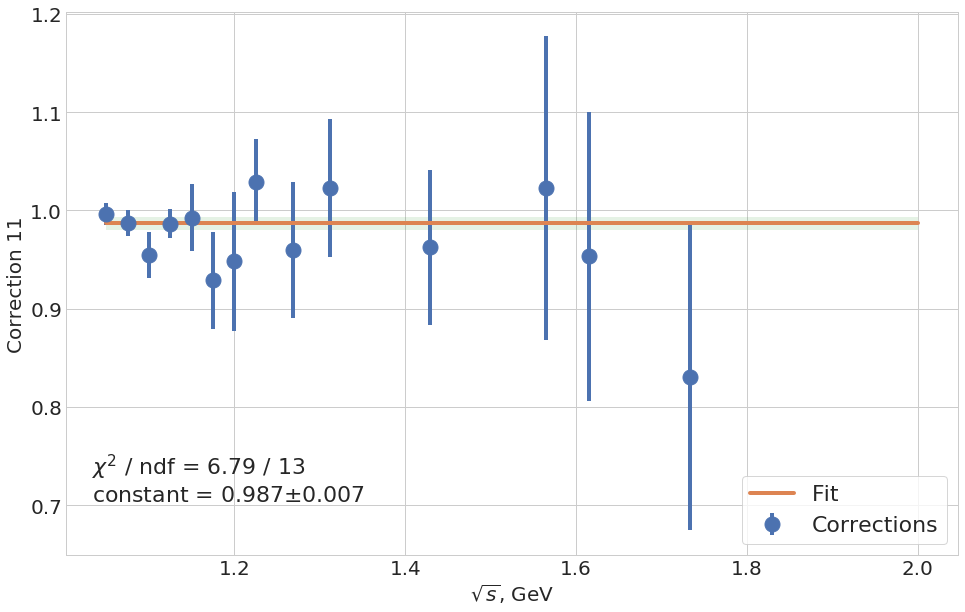

In [74]:
#plot corrections
plt.errorbar(x=rec[year]['label']*2e-3, y=rec[year]['correction'], yerr=rec[year]['correction_error'], 
             fmt='o', label='Corrections', lw=4, ms=15)

#plot fitting line
x_line, y_line = np.linspace(1.05, 2., 2), m.np_values()[0]*np.ones(2)
yerr_line = np.ones(2)*m.np_errors()[0]
plt.plot(x_line, y_line, label='Fit', lw=4)
plt.fill_between(x_line, y_line-yerr_line, y_line+yerr_line, facecolor='green', alpha=0.1, edgecolor='none')

#look friendly
plt.xlabel("$\sqrt{s}$, GeV", fontsize=20);
plt.ylabel(f"Correction {year}", fontsize=20);
ax = plt.gca()
ax.tick_params(labelsize=20)
    #text and legend
text_str = f"$\chi^2$ / ndf = {m.fval:.2f} / {len(rec[year])-1} \nconstant = {m.np_values()[0]:.3f}$\pm${m.np_errors()[0]:.3f}"
ax.text(0.03, 0.1, text_str, transform=ax.transAxes, fontsize=22)
plt.legend(fontsize=22, loc='lower right', frameon=True);

# plt.savefig('correction11n.pdf')